# 02 Implementing Backpropagation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we add the `_backward()` function that calculates how the output gradient propagates in the input gradient. For example, given the expression

$$c = a * b$$

the `_backward()` function will calculate how the gradient of $c$ propagates into the gradients of $a$ and $b$, namely as

$$\frac{dL}{da} = \frac{dL}{dc} * b$$

and

$$\frac{dL}{db} = \frac{dL}{dc} * a$$

based on what we derived in the [Manual Backpropagation notebook](micrograd.ipynb). Note that within the `Value` class, we will store pointers to the `_backward()` function rather than calling these functions. This is needed so we can call the `_backward()` functions in the right order (i.e., starting from the last node in the expression). So, this implementation of backpropagation essentially uses callbacks.

In [2]:
class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._backward = lambda: None # defines how to propagate the output gradient to the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        def _backward():
            # For addition, the local derivative is always 1. So, given the expression a = b + c, it follows from the chain rule 
            # dz/dx = dz/dy*dy/dx that the gradients of b and c are (1.0 * the gradient of a)
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        if isinstance(other, Value):
            out = Value(self.data + other.data, (self, other), '+')
            out._backward = _backward
            return out
        else:
            out = Value(self.data + other, (self,), '+')
            out._backward = _backward
            return out
        
    def __mul__(self, other):
        def _backward():
            # For multiplication, the local derivative is always the other value (because for z=x*y, dz/dx = y). 
            # So, given the expression a = b * c, it follows from the chain rule that the gradient of b
            # is (c * the gradient of a), and the gradient of c is (b * the gradient of a).
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        if isinstance(other, Value):
            out = Value(self.data * other.data, (self, other), '*')
            out._backward = _backward
            return out
        else:
            out = Value(self.data * other, (self,), '*')
            out._backward = _backward
            return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

To vizualize what's happening, we'll re-use the drawing code from the [Manual Backpropagation notebook](micrograd.ipynb):

In [3]:
# Code for visualizing the graph
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle node for it ('record')
        dot.node(name = uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # if the value was produced by an operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot

With this, we can now compute backpropagation for the following example:

In [4]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the neuron
b = Value(6.8813735870195432, label='b')
# input to the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output of the neuron
o = n.tanh(); o.label = 'o'

We first vizualize the initial propagation graph (all gradients are 0): 

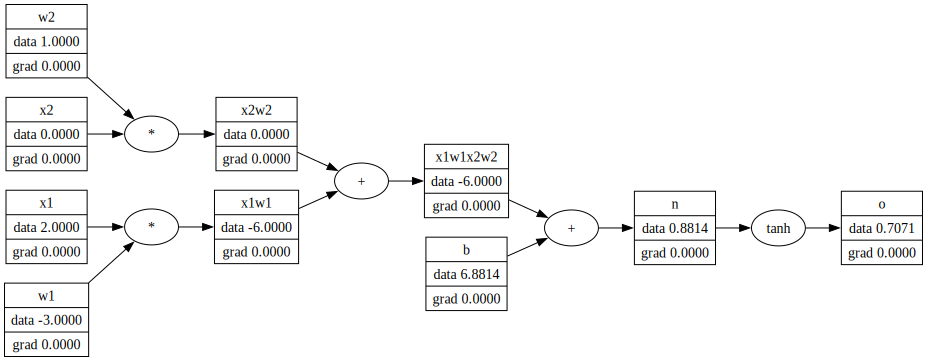

In [5]:
draw_dot(o)

We then call `_backward()` in the right order to compute the gradients:

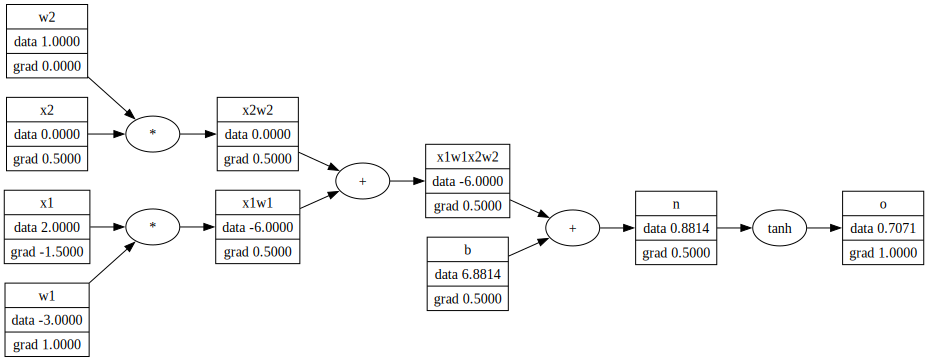

In [6]:
# Set o.grad to 1.0 because in the Value class, the gradient is initialized to 0.0
o.grad = 1.0
# Compute the gradients
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# Vizualize the gradients again
draw_dot(o)

Now, to perform the backpropagation without calling `_backward()` manually, we need to ensure that it is called in the correct order: first all the value have to propagate until the final node and then we can run backpropagation. This can be achieved with _topological sort_, a layout of a graph where all edges go from left to right: 

In [7]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

topo

[Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2w2),
 Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=6.881373587019543, label=b),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=o)]

 Now that we have the topological order, we can compute the gradients for each node by simply calling `_backward()` for every element in `topo` in _reversed_ order from `topo[-1]` to `topo[0]`:

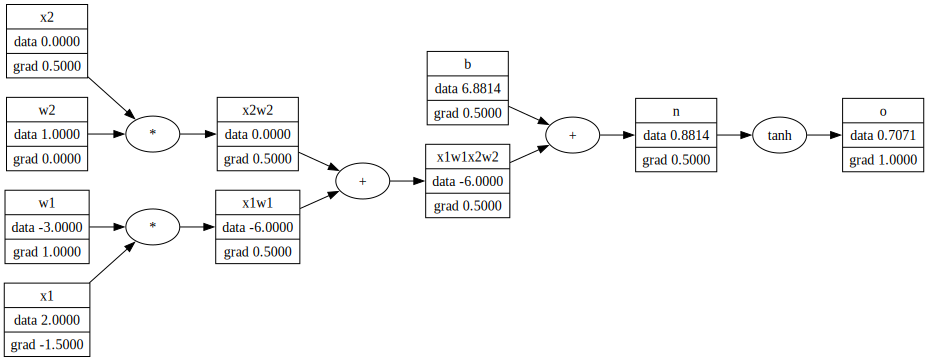

In [8]:
# First, redefine the expression to have all gradients set to 0.0
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the neuron
b = Value(6.8813735870195432, label='b')
# input to the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output of the neuron
o = n.tanh(); o.label = 'o'

# Set o.grad to 1.0 because in the Value class, the gradient is initialized to 0.0
o.grad = 1.0
# Compute the gradients
topo = []
visited = set()
build_topo(o)

for node in reversed(topo):
    node._backward()


# Vizualize the gradients again
draw_dot(o)

Finally, we can pull the `build_topo()` method into the `Value` class: 

In [9]:
class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._backward = lambda: None # defines how to propagate the output gradient to the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        def _backward():
            # For addition, the local derivative is always 1. So, given the expression a = b + c, it follows from the chain rule 
            # dz/dx = dz/dy*dy/dx that the gradients of b and c are (1.0 * the gradient of a)
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        if isinstance(other, Value):
            out = Value(self.data + other.data, (self, other), '+')
            out._backward = _backward
            return out
        else:
            out = Value(self.data + other, (self,), '+')
            out._backward = _backward
            return out
        
    def __mul__(self, other):
        def _backward():
            # For multiplication, the local derivative is always the other value (because for z=x*y, dz/dx = y). 
            # So, given the expression a = b * c, it follows from the chain rule that the gradient of b
            # is (c * the gradient of a), and the gradient of c is (b * the gradient of a).
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        if isinstance(other, Value):
            out = Value(self.data * other.data, (self, other), '*')
            out._backward = _backward
            return out
        else:
            out = Value(self.data * other, (self,), '*')
            out._backward = _backward
            return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

With class `Value` having the `backward` method implemented, we can now call it on the last node of our graph without any intermediate steps:

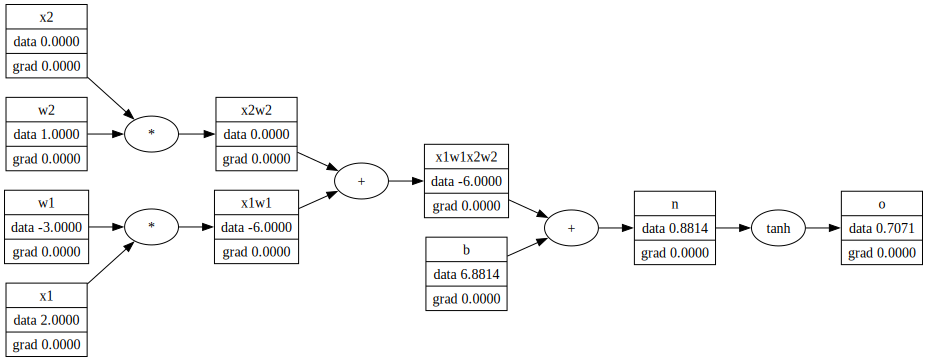

In [10]:
# Redefine the values so all gradients are set to 0.0
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the neuron
b = Value(6.8813735870195432, label='b')
# input to the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output of the neuron
o = n.tanh(); o.label = 'o'
draw_dot(o)

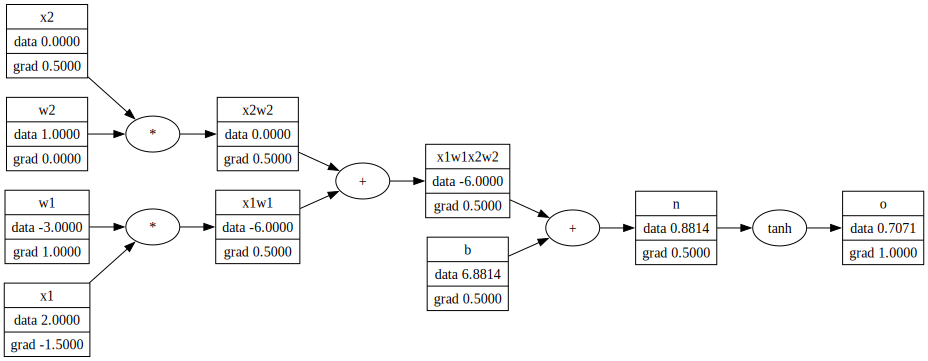

In [11]:
# Compute the gradients
o.backward()

# Vizualize the gradients again
draw_dot(o)

So far, the code in `Value` can only deal with expressions where every variable is used once. In contrast, if we had an expression like

$$b = a + a$$

the current code would "overwrite" the gradient of $a$ (because db/da = 2, not 1 in this case). To fix that, we need to accumulate the gradients with `self.grad +=` and `other.grad +=`. In addition, we'll fix the issue that `a * 2` works (because we have defined how to multiply `Value` with non-`Value`) but not `2 * a` by adding the `__rmul__` method which Python automatically looks for if it doesn't know how to multiply built-in data type with `Value`. We will also add exponentiation and division.

In [12]:
class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._backward = lambda: None # defines how to propagate the output gradient to the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        def _backward():
            # For addition, the local derivative is always 1. So, given the expression a = b + c, it follows from the chain rule 
            # dz/dx = dz/dy*dy/dx that the gradients of b and c are (1.0 * the gradient of a)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        if isinstance(other, Value):
            out = Value(self.data + other.data, (self, other), '+')
            out._backward = _backward
            return out
        else:
            out = Value(self.data + other, (self,), '+')
            out._backward = _backward
            return out
        
    def __neg__(self): #-self
        return self * -1
        
    def __sub__(self, other): #self - other, uses __neg__ and __add__
        return self + (-other)
        
    def __mul__(self, other):
        def _backward():
            # For multiplication, the local derivative is always the other value (because for z=x*y, dz/dx = y). 
            # So, given the expression a = b * c, it follows from the chain rule that the gradient of b
            # is (c * the gradient of a), and the gradient of c is (b * the gradient of a).
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        if isinstance(other, Value):
            out = Value(self.data * other.data, (self, other), '*')
            out._backward = _backward
            return out
        else:
            out = Value(self.data * other, (self,), '*')
            out._backward = _backward
            return out
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # because d/dx e^x = e^x
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

Now we can check that backpropagation is correct for the following code (the gradient of $a$ must be 2.0, not 1.0):

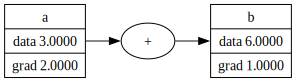

In [13]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)